In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.multitest import multipletests
import latex

In [2]:
data = pd.read_excel('S1File.xlsx', sheet_name = 'CFS_JPT_Seroarray')
data = data.iloc[1254:1272]

In [3]:
infections = pd.read_csv('epi_data_age_gender.csv')
healthy_idxs = list(infections[infections.Group == 'HC'].ID)
uninf_idxs = list(infections[(infections.Group != 'HC') & (infections.Infection != 'Yes')].ID)

In [4]:
lower_bound = []
upper_bound = []
min_p_value = []
sequence = []
antibody = []

all_p_values = {}
all_lower_bounds = {}
all_upper_bounds = {}
uninfected_proportions = {}
healthy_proportions = {}

for j in range(18):

    uninfected_proportions_iter = []
    healthy_proportions_iter = []
    
    sequence.append(data.iloc[j, 1])
    antibody.append(data.iloc[j, 0][-4:])
    
    row = data.iloc[j, 8:]
    row = row[healthy_idxs + uninf_idxs]
    uninfected = np.array(row[uninf_idxs])
    healthy = np.array(row[healthy_idxs])
    row = sorted(list(row))

    thr_lower_bound = []
    thr_upper_bound = []
    p_values = []
    for i in range(len(row)-1):
        thr = row[i]
        uninfected_above = (uninfected > thr).sum()
        uninfected_below = len(uninf_idxs) - uninfected_above
        healthy_above = (healthy > thr).sum()
        healthy_below = len(healthy_idxs) - healthy_above
        
        test = chi2_contingency(np.array([[uninfected_above, uninfected_below], [healthy_above, healthy_below]]))
        thr_lower_bound.append(thr)
        thr_upper_bound.append(row[i+1])
        p_values.append(test[1])
        
        uninfected_proportions_iter.append(uninfected_above/len(uninf_idxs))
        healthy_proportions_iter.append(healthy_above/len(healthy_idxs))
    
    idx = np.where(p_values == min(p_values))[0][0]
    
    all_p_values[sequence[-1]] = p_values
    all_lower_bounds[sequence[-1]] = thr_lower_bound
    all_upper_bounds[sequence[-1]] = thr_upper_bound
    
    lower_bound.append(thr_lower_bound[idx])
    upper_bound.append(thr_upper_bound[idx])
    min_p_value.append(min(p_values))
    uninfected_proportions[sequence[-1]] = uninfected_proportions_iter[idx]
    healthy_proportions[sequence[-1]] = healthy_proportions_iter[idx]

In [5]:
summary = pd.DataFrame({'sequence':sequence, 'antibody':antibody, 'lower_bound':lower_bound, 
                        'upper_bound':upper_bound, 'min_p_value':min_p_value, 'uninfected_prop': uninfected_proportions.values(),
                       'healthy_prop': healthy_proportions.values()})

In [6]:
summary

,sequence,antibody,lower_bound,upper_bound,min_p_value,uninfected_prop,healthy_prop
0,FEYHQEGGPDGEPDM,0415,987.000000,997.666667,0.001507,0.894737,0.56
1,FEYHQEGGPDGEPDV,0415,939.000000,963.333333,0.034439,0.973684,0.80
2,QEGGPDGEPDMPPGA,0419,844.000000,845.666667,0.178873,0.894737,0.76
3,QEGGPDGEPDVPPGA,0419,1033.333333,1034.000000,0.020677,0.710526,0.44
4,PDGEPDMPPGAIEQG,0423,866.666667,871.500000,0.026980,1.000000,0.84
5,PDGEPDVPPGAIEQG,0423,1195.666667,1197.333333,0.040382,0.842105,0.62
6,PDVPPGAIEQGPTDD,0427,928.666667,949.333333,0.134204,0.921053,0.78
7,PPGAIEQGPADDPGE,0430,873.666667,889.333333,0.044809,1.000000,0.86
8,PGAIEQGPTDDPGEG,0431,933.000000,933.666667,0.011503,0.868421,0.60
9,IEQGPADDPGEGPST,0434,923.333333,929.333333,0.018761,0.868421,0.62


In [7]:
summary[['uninfected_prop_min', 'uninfected_prop_max', 'healthy_prop_min', 'healthy_prop_max']]= np.nan
for i in range(18):
    summary.iloc[i, 7:9] = proportion_confint(int((summary.uninfected_prop[i])*len(uninf_idxs)), len(uninf_idxs), alpha=0.05, method='normal')
    summary.iloc[i, 9:11] = proportion_confint(int((summary.healthy_prop[i]*len(healthy_idxs))), len(healthy_idxs), alpha=0.05, method='normal')
    
summary['antibody'] = summary['antibody']
summary.loc[[1,3,5,15,17],'antibody'] = summary.loc[[1,3,5,15,17],'antibody'] + '_'

In [8]:
bounds_ = []
for k, v in all_p_values.items():
    bounds_.append(np.log10(all_lower_bounds[k][all_p_values[k].index(min(all_p_values[k]))]))

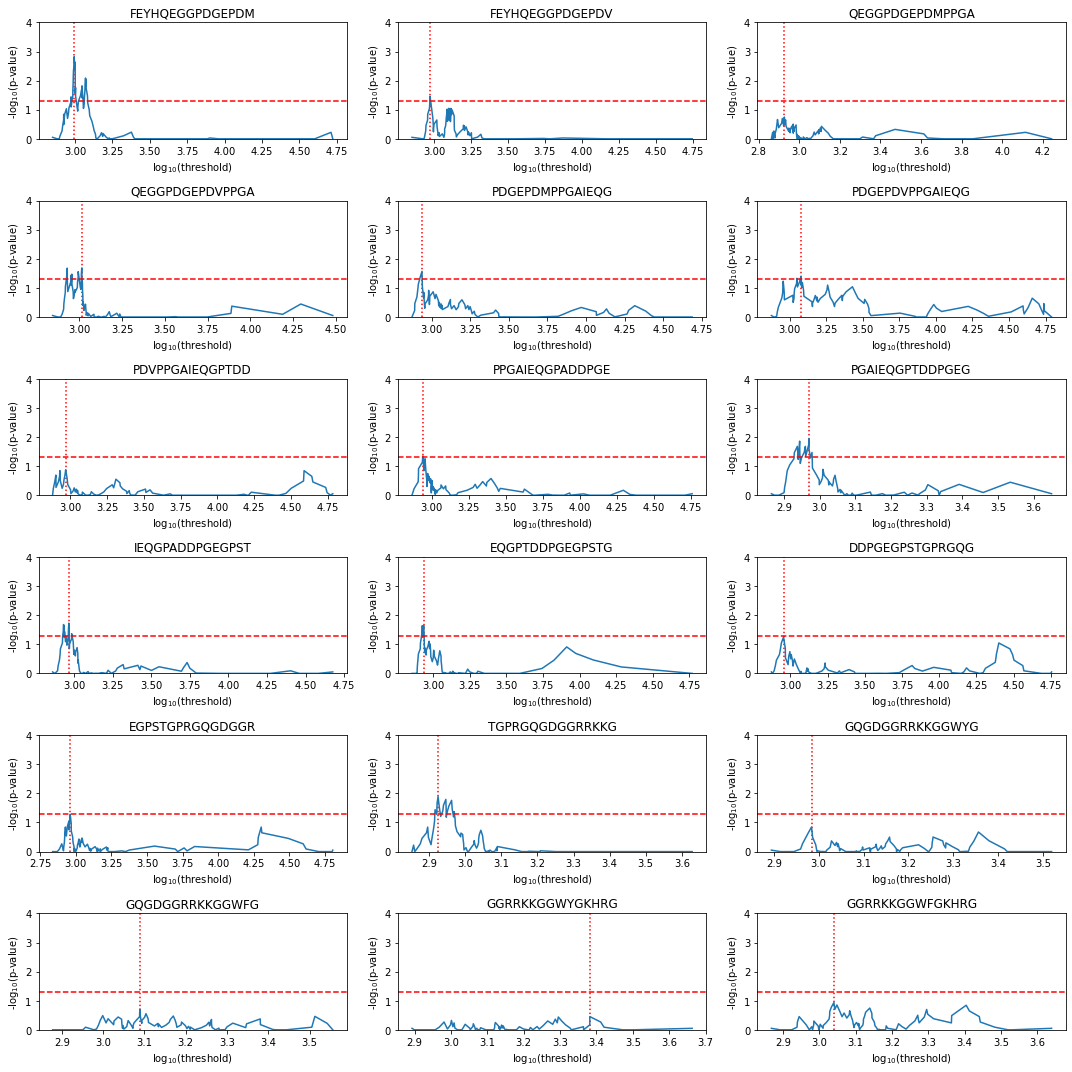

In [9]:
fig, axs = plt.subplots(6, 3, figsize = (15,15))
sequence = list(summary.sequence)
for i in range(6):
    for j in range(3):
        axs[i, j].plot(np.log10(np.array(all_lower_bounds[sequence[3*i+j]])), -np.log10(np.array(all_p_values[sequence[3*i+j]])))
        axs[i, j].set_title(sequence[3*i+j])
        axs[i, j].set_xlabel(r'log$_{10}$(threshold)')
        axs[i, j].set_ylabel(r'-log$_{10}$(p-value)')
        axs[i, j].set_ylim([0, 4])
        axs[i, j].vlines(bounds_[3*i+j], ymin = 0, ymax = 4, color = 'red', linestyles = 'dotted')
        axs[i, j].axhline(-np.log10(0.05), ls = '--', color = 'red')
fig.tight_layout()
fig.savefig("plots/uninfected_healthy/"+str(1)+".png", facecolor='white', edgecolor='none', dpi=600)
plt.show()

In [10]:
summary

,sequence,antibody,lower_bound,upper_bound,min_p_value,uninfected_prop,healthy_prop,uninfected_prop_min,uninfected_prop_max,healthy_prop_min,healthy_prop_max
0,FEYHQEGGPDGEPDM,0415,987.000000,997.666667,0.001507,0.894737,0.56,0.797161,0.992313,0.422411,0.697589
1,FEYHQEGGPDGEPDV,0415_,939.000000,963.333333,0.034439,0.973684,0.80,0.922789,1.000000,0.689128,0.910872
2,QEGGPDGEPDMPPGA,0419,844.000000,845.666667,0.178873,0.894737,0.76,0.797161,0.992313,0.641621,0.878379
3,QEGGPDGEPDVPPGA,0419_,1033.333333,1034.000000,0.020677,0.710526,0.44,0.566331,0.854722,0.302411,0.577589
4,PDGEPDMPPGAIEQG,0423,866.666667,871.500000,0.026980,1.000000,0.84,1.000000,1.000000,0.738384,0.941616
5,PDGEPDVPPGAIEQG,0423_,1195.666667,1197.333333,0.040382,0.842105,0.62,0.726168,0.958043,0.485460,0.754540
6,PDVPPGAIEQGPTDD,0427,928.666667,949.333333,0.134204,0.921053,0.78,0.835316,1.000000,0.665179,0.894821
7,PPGAIEQGPADDPGE,0430,873.666667,889.333333,0.044809,1.000000,0.86,1.000000,1.000000,0.763822,0.956178
8,PGAIEQGPTDDPGEG,0431,933.000000,933.666667,0.011503,0.868421,0.60,0.760944,0.975898,0.464210,0.735790
9,IEQGPADDPGEGPST,0434,923.333333,929.333333,0.018761,0.868421,0.62,0.760944,0.975898,0.485460,0.754540


In [11]:
summary_uninfected = summary.copy()
summary_uninfected['type'] = 'uninfected'
summary_uninfected['prop'] = summary_uninfected.uninfected_prop
summary_uninfected['prop_max'] = summary_uninfected.uninfected_prop_max
summary_uninfected['prop_min'] = summary_uninfected.uninfected_prop_min
summary_healthy = summary.copy()
summary_healthy['type'] = 'healthy'
summary_healthy['prop'] = summary_healthy.healthy_prop
summary_healthy['prop_max'] = summary_healthy.healthy_prop_max
summary_healthy['prop_min'] = summary_healthy.healthy_prop_min 
summary_healthy['antibody'] = summary_healthy['antibody'] + '?'
summary_violin = pd.concat([summary_uninfected, summary_healthy])

In [12]:
ants = list(summary.antibody.apply(lambda x: x[:-1] if '_' in x else x).astype(int))

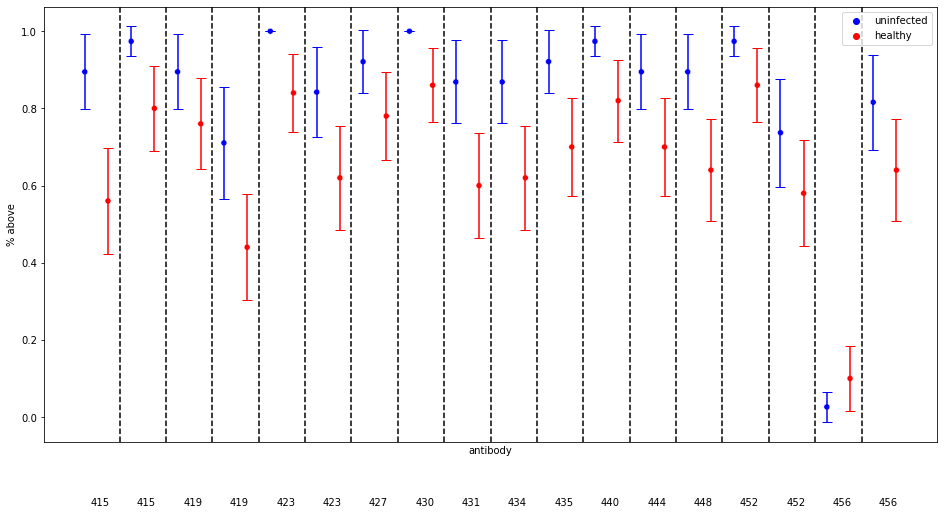

In [13]:
summary_violin = summary_violin.sort_values('antibody')
fig = plt.figure(figsize=(16, 8))
ax = sns.scatterplot(data =summary_violin, x = 'antibody', y = 'prop', hue = 'type', 
                     palette = {'uninfected':'blue', 'healthy':'red'})
ax.legend(title='')
yerr = (summary_violin.prop_max - summary_violin.prop_min)/2
plt.errorbar(x=summary_violin.antibody[::2], y=summary_violin.prop[::2], yerr=yerr[::2], fmt='none', c= 'blue', capsize=5)
plt.errorbar(x=summary_violin.antibody[1::2], y=summary_violin.prop[1::2], yerr=yerr[1::2], fmt='none', c= 'red', capsize=5)
plt.ylabel('% above')
plt.xlabel('antibody')
plt.xticks([])
for i in range(18):
    if i != 17:
        ax.axvline(2*i+1.5, ls = '--', color = 'black')
    plt.text(2*i+0.25, -0.23, ants[i])
fig.savefig("plots/uninfected_healthy/"+str(2)+".png", facecolor='white', edgecolor='none', dpi=1200)
plt.show()

In [14]:
summary.antibody = ants

In [15]:
summary

,sequence,antibody,lower_bound,upper_bound,min_p_value,uninfected_prop,healthy_prop,uninfected_prop_min,uninfected_prop_max,healthy_prop_min,healthy_prop_max
0,FEYHQEGGPDGEPDM,415,987.000000,997.666667,0.001507,0.894737,0.56,0.797161,0.992313,0.422411,0.697589
1,FEYHQEGGPDGEPDV,415,939.000000,963.333333,0.034439,0.973684,0.80,0.922789,1.000000,0.689128,0.910872
2,QEGGPDGEPDMPPGA,419,844.000000,845.666667,0.178873,0.894737,0.76,0.797161,0.992313,0.641621,0.878379
3,QEGGPDGEPDVPPGA,419,1033.333333,1034.000000,0.020677,0.710526,0.44,0.566331,0.854722,0.302411,0.577589
4,PDGEPDMPPGAIEQG,423,866.666667,871.500000,0.026980,1.000000,0.84,1.000000,1.000000,0.738384,0.941616
5,PDGEPDVPPGAIEQG,423,1195.666667,1197.333333,0.040382,0.842105,0.62,0.726168,0.958043,0.485460,0.754540
6,PDVPPGAIEQGPTDD,427,928.666667,949.333333,0.134204,0.921053,0.78,0.835316,1.000000,0.665179,0.894821
7,PPGAIEQGPADDPGE,430,873.666667,889.333333,0.044809,1.000000,0.86,1.000000,1.000000,0.763822,0.956178
8,PGAIEQGPTDDPGEG,431,933.000000,933.666667,0.011503,0.868421,0.60,0.760944,0.975898,0.464210,0.735790
9,IEQGPADDPGEGPST,434,923.333333,929.333333,0.018761,0.868421,0.62,0.760944,0.975898,0.485460,0.754540


In [16]:
ag876 = 'FEYHQEGGPDGEPDMPPGAIEQGPADDPGEGPSTGPRGQGDGGRRKKGGWYGKHRG'
ag876_stop = [15, 19, 23, 30, 34, 40, 44, 48, 52, 56]
ag876_target = 16
b958 = 'FEYHQEGGPDGEPDVPPGAIEQGPADDPGEGPSTGPRGQGDGGRRKKGGWFGKHRG'
b958_stop = [15, 19, 23, 30, 34, 40, 44, 48, 52, 56]
b958_target = 16
gd1 = 'QEGGPDGEPDVPPGAIEQGPTDDPGEGPSTGPRGQGDGGRRKKGGWFGKHRG'
gd1_stop = [15, 19, 23, 27, 31, 36, 40, 44, 48, 52]
gd1_target = 12

In [17]:
adj_p_values_bonf = -np.log10(multipletests(np.array(summary['min_p_value']), method = 'bonferroni')[1])
adj_p_values_fdr = -np.log10(multipletests(np.array(summary['min_p_value']), method = 'fdr_bh')[1])

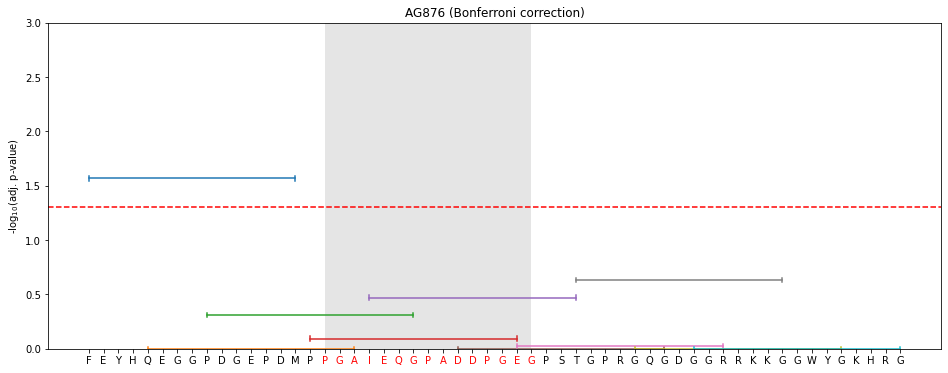

In [18]:
adj_p_values = adj_p_values_bonf[data['AG876'] == 'x']
fig, ax = plt.subplots(figsize=(16, 6))
for i in range(len(ag876_stop)):
    p = plt.plot(list(range(ag876_stop[i]-15, ag876_stop[i])), (adj_p_values[i],)*15)
    col = p[0].get_color()
    plt.plot((ag876_stop[i]-15,)*5, np.linspace(adj_p_values[i]-0.02, adj_p_values[i]+0.02, 5), col)
    plt.plot((ag876_stop[i]-1,)*5, np.linspace(adj_p_values[i]-0.02, adj_p_values[i]+0.02, 5), col)
plt.xticks(range(len(ag876)), ag876)
plt.ylabel(r'-log$_{10}$(adj. p-value)')
plt.title('AG876 (Bonferroni correction)')
plt.axhline(-np.log10(0.05), ls = '--', color = 'red')
[i.set_color("red") for i in plt.gca().get_xticklabels()[ag876_target:(ag876_target+15)]]
plt.axvspan(ag876_target, ag876_target+14, facecolor='grey', alpha=0.2)
ax.set_ylim([0, 3])
fig.savefig("plots/uninfected_healthy/"+str(3)+".png", facecolor='white', edgecolor='none', dpi=600)
plt.show()

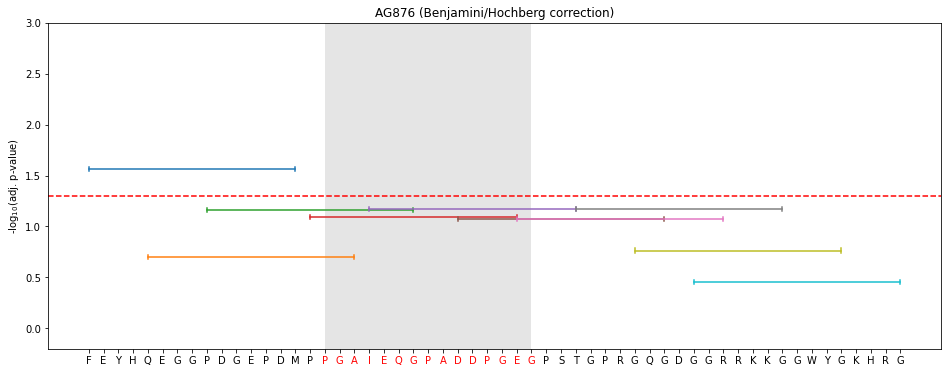

In [19]:
adj_p_values = adj_p_values_fdr[data['AG876'] == 'x']
fig, ax = plt.subplots(figsize=(16, 6))
for i in range(len(ag876_stop)):
    p = plt.plot(list(range(ag876_stop[i]-15, ag876_stop[i])), (adj_p_values[i],)*15)
    col = p[0].get_color()
    plt.plot((ag876_stop[i]-15,)*5, np.linspace(adj_p_values[i]-0.02, adj_p_values[i]+0.02, 5), col)
    plt.plot((ag876_stop[i]-1,)*5, np.linspace(adj_p_values[i]-0.02, adj_p_values[i]+0.02, 5), col)
plt.xticks(range(len(ag876)), ag876)
plt.ylabel(r'-log$_{10}$(adj. p-value)')
plt.title('AG876 (Benjamini/Hochberg correction)')
plt.axhline(-np.log10(0.05), ls = '--', color = 'red')
[i.set_color("red") for i in plt.gca().get_xticklabels()[ag876_target:(ag876_target+15)]]
plt.axvspan(ag876_target, ag876_target+14, facecolor='grey', alpha=0.2)
ax.set_ylim([-0.2, 3])
fig.savefig("plots/uninfected_healthy/"+str(4)+".png", facecolor='white', edgecolor='none', dpi=600)
plt.show()

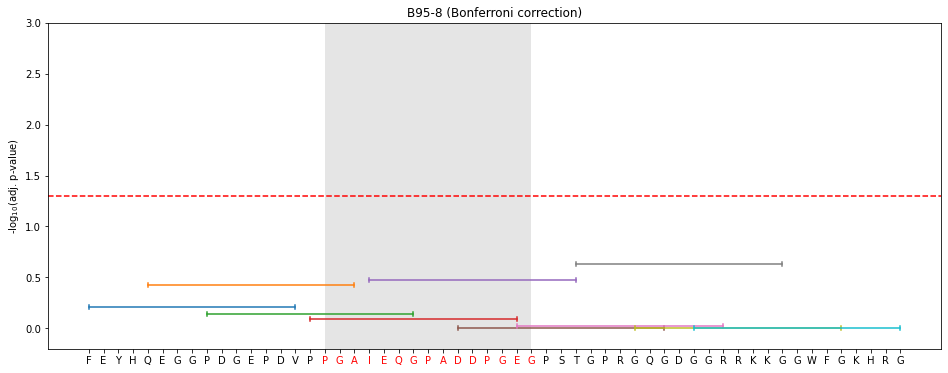

In [20]:
adj_p_values = adj_p_values = adj_p_values_bonf[data['B95-8'] == 'x']
fig, ax = plt.subplots(figsize=(16, 6))
for i in range(len(b958_stop)):
    p = plt.plot(list(range(b958_stop[i]-15, b958_stop[i])), (adj_p_values[i],)*15)
    col = p[0].get_color()
    plt.plot((b958_stop[i]-15,)*5, np.linspace(adj_p_values[i]-0.02, adj_p_values[i]+0.02, 5), col)
    plt.plot((b958_stop[i]-1,)*5, np.linspace(adj_p_values[i]-0.02, adj_p_values[i]+0.02, 5), col)
plt.xticks(range(len(b958)), b958)
plt.ylabel(r'-log$_{10}$(adj. p-value)')
plt.title('B95-8 (Bonferroni correction)')
plt.axhline(-np.log10(0.05), ls = '--', color = 'red')
[i.set_color("red") for i in plt.gca().get_xticklabels()[b958_target:(b958_target+15)]]
plt.axvspan(b958_target, b958_target+14, facecolor='grey', alpha=0.2)
ax.set_ylim([-0.2, 3])
fig.savefig("plots/uninfected_healthy/"+str(5)+".png", facecolor='white', edgecolor='none', dpi=600)
plt.show()

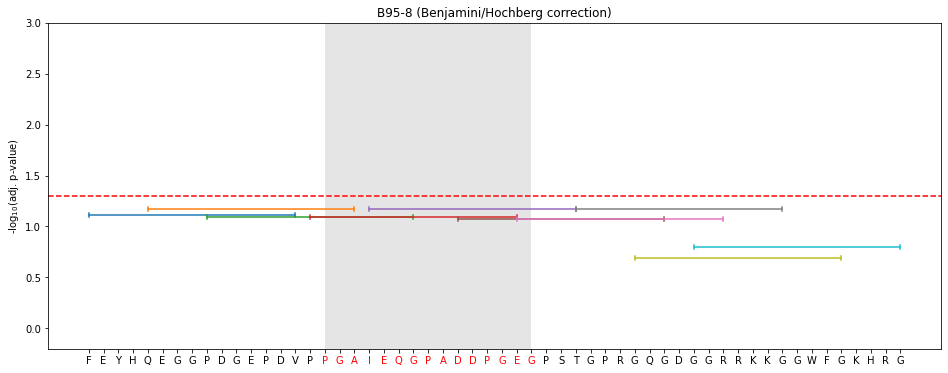

In [21]:
adj_p_values = adj_p_values = adj_p_values_fdr[data['B95-8'] == 'x']
fig, ax = plt.subplots(figsize=(16, 6))
for i in range(len(b958_stop)):
    p = plt.plot(list(range(b958_stop[i]-15, b958_stop[i])), (adj_p_values[i],)*15)
    col = p[0].get_color()
    plt.plot((b958_stop[i]-15,)*5, np.linspace(adj_p_values[i]-0.02, adj_p_values[i]+0.02, 5), col)
    plt.plot((b958_stop[i]-1,)*5, np.linspace(adj_p_values[i]-0.02, adj_p_values[i]+0.02, 5), col)
plt.xticks(range(len(b958)), b958)
plt.ylabel(r'-log$_{10}$(adj. p-value)')
plt.title('B95-8 (Benjamini/Hochberg correction)')
plt.axhline(-np.log10(0.05), ls = '--', color = 'red')
[i.set_color("red") for i in plt.gca().get_xticklabels()[b958_target:(b958_target+15)]]
plt.axvspan(b958_target, b958_target+14, facecolor='grey', alpha=0.2)
ax.set_ylim([-0.2, 3])
fig.savefig("plots/uninfected_healthy/"+str(6)+".png", facecolor='white', edgecolor='none', dpi=600)
plt.show()

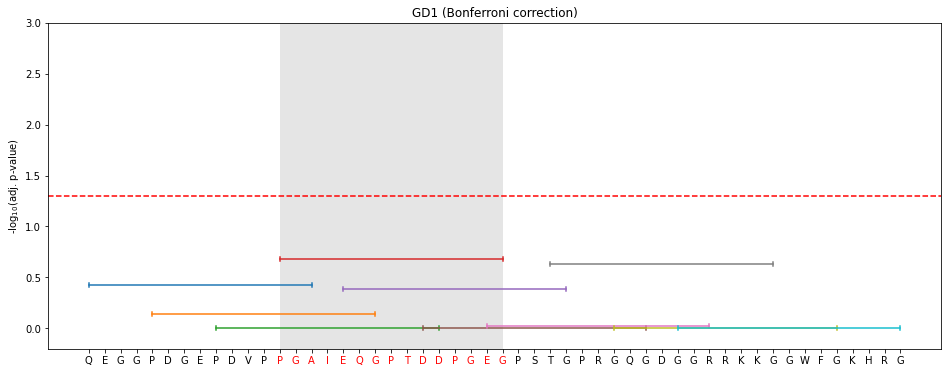

In [22]:
adj_p_values = adj_p_values = adj_p_values_bonf[data['GD1'] == 'x']
fig, ax = plt.subplots(figsize=(16, 6))
for i in range(len(gd1_stop)):
    p = plt.plot(list(range(gd1_stop[i]-15, gd1_stop[i])), (adj_p_values[i],)*15)
    col = p[0].get_color()
    plt.plot((gd1_stop[i]-15,)*5, np.linspace(adj_p_values[i]-0.02, adj_p_values[i]+0.02, 5), col)
    plt.plot((gd1_stop[i]-1,)*5, np.linspace(adj_p_values[i]-0.02, adj_p_values[i]+0.02, 5), col)
plt.xticks(range(len(gd1)), gd1)
plt.ylabel(r'-log$_{10}$(adj. p-value)')
plt.title('GD1 (Bonferroni correction)')
plt.axhline(-np.log10(0.05), ls = '--', color = 'red')
[i.set_color("red") for i in plt.gca().get_xticklabels()[gd1_target:(gd1_target+15)]]
plt.axvspan(gd1_target, gd1_target+14, facecolor='grey', alpha=0.2)
ax.set_ylim([-0.2, 3])
fig.savefig("plots/uninfected_healthy/"+str(7)+".png", facecolor='white', edgecolor='none', dpi=600)
plt.show()

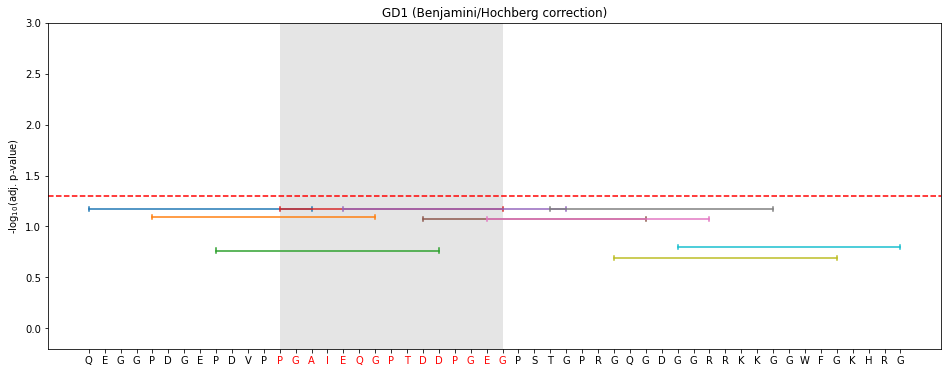

In [23]:
adj_p_values = adj_p_values = adj_p_values_fdr[data['GD1'] == 'x']
fig, ax = plt.subplots(figsize=(16, 6))
for i in range(len(gd1_stop)):
    p = plt.plot(list(range(gd1_stop[i]-15, gd1_stop[i])), (adj_p_values[i],)*15)
    col = p[0].get_color()
    plt.plot((gd1_stop[i]-15,)*5, np.linspace(adj_p_values[i]-0.02, adj_p_values[i]+0.02, 5), col)
    plt.plot((gd1_stop[i]-1,)*5, np.linspace(adj_p_values[i]-0.02, adj_p_values[i]+0.02, 5), col)
plt.xticks(range(len(gd1)), gd1)
plt.ylabel(r'-log$_{10}$(adj. p-value)')
plt.title('GD1 (Benjamini/Hochberg correction)')
plt.axhline(-np.log10(0.05), ls = '--', color = 'red')
[i.set_color("red") for i in plt.gca().get_xticklabels()[gd1_target:(gd1_target+15)]]
plt.axvspan(gd1_target, gd1_target+14, facecolor='grey', alpha=0.2)
ax.set_ylim([-0.2, 3])
fig.savefig("plots/uninfected_healthy/"+str(8)+".png", facecolor='white', edgecolor='none', dpi=600)
plt.show()